In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_original = pd.read_csv("dadosProb.csv", encoding="ISO-8859-1") #Fazendo os dados do excel serem lidos

In [3]:
print(df_original.columns)

Index(['id', 'data', 'dia_semana', 'horario', 'uf', 'br', 'km', 'municipio',
       'CAUSA_ACIDENTE', 'TIPO_ACIDENTE', 'classificacao_acidente', 'fase_dia',
       'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via',
       'uso_solo', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves',
       'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude',
       'regional', 'delegacia', 'uop'],
      dtype='object')


In [4]:
def classificar_variaveis(df):
    """
    Classifica automaticamente as variáveis de um DataFrame em:
    - Identificador
    - Quantitativa Discreta
    - Quantitativa Contínua
    - Quantitativa Contínua (Temporal)
    - Qualitativa Nominal
    - Qualitativa Ordinal
    
    Corrige casos específicos do dataset da PRF:
    - 'br' é qualitativa nominal
    - 'km' é transformada em numérica (contínua)
    - latitude/longitude sempre contínuas
    - id é identificador
    """

    # Converte km para numérico (corrige strings)
    if "km" in df.columns:
        df["km"] = pd.to_numeric(df["km"], errors="coerce")

    classificacao = []

    # Palavras típicas de escalas ordinais
    ordinais_comuns = {
        "baixo", "médio", "medio", "alto",
        "ruim", "regular", "bom", "ótimo", "otimo",
        "pequeno", "médio", "medio", "grande"
    }

    for coluna in df.columns:

        serie = df[coluna]
        valores = serie.dropna()
        dtype = serie.dtype
        nome = coluna.lower()

        # ---------------------------------------------------
        # 1. Identificadores
        # ---------------------------------------------------
        if nome in ["id", "codigo", "cod", "identificador"]:
            natureza = "Identificador"

        # ---------------------------------------------------
        # 2. Variáveis temporais
        # ---------------------------------------------------
        elif pd.api.types.is_datetime64_any_dtype(serie):
            natureza = "Quantitativa Contínua (Temporal)"

        elif nome in ["data", "dia", "data_acidente", "horario", "hora"]:
            natureza = "Quantitativa Contínua (Temporal)"

        # ---------------------------------------------------
        # 3. Casos especiais do dataset da PRF
        # ---------------------------------------------------
        elif nome == "br":
            natureza = "Qualitativa Nominal"

        elif nome in ["km"]:
            natureza = "Quantitativa Contínua"

        elif nome in ["latitude", "longitude", "lat", "lon"]:
            natureza = "Quantitativa Contínua"

        # ---------------------------------------------------
        # 4. Variáveis Numéricas Comuns
        # ---------------------------------------------------
        elif pd.api.types.is_numeric_dtype(serie):

            # Se todos são inteiros → discreta
            if (valores.astype(float) % 1 == 0).all():
                natureza = "Quantitativa Discreta"
            else:
                natureza = "Quantitativa Contínua"

        # ---------------------------------------------------
        # 5. Variáveis Categóricas (Nominal ou Ordinal)
        # ---------------------------------------------------
        else:
            valores_str = valores.astype(str).str.lower()

            if any(v in ordinais_comuns for v in valores_str):
                natureza = "Qualitativa Ordinal"
            else:
                natureza = "Qualitativa Nominal"

        classificacao.append([coluna, natureza])

    # Monta a tabela final
    tabela = pd.DataFrame(classificacao, columns=["Variável", "Classificação"])

    # Contagem dos tipos
    contagem = tabela["Classificação"].value_counts().rename("Quantidade").reset_index()
    contagem = contagem.rename(columns={"index": "Tipo"})

    return tabela, contagem


In [5]:
tabela, contagem = classificar_variaveis(df_original)

print("=== Classificação das Variáveis ===")
print(tabela)


=== Classificação das Variáveis ===
                  Variável                     Classificação
0                       id                     Identificador
1                     data  Quantitativa Contínua (Temporal)
2               dia_semana               Qualitativa Nominal
3                  horario  Quantitativa Contínua (Temporal)
4                       uf               Qualitativa Nominal
5                       br               Qualitativa Nominal
6                       km             Quantitativa Contínua
7                municipio               Qualitativa Nominal
8           CAUSA_ACIDENTE               Qualitativa Nominal
9            TIPO_ACIDENTE               Qualitativa Nominal
10  classificacao_acidente               Qualitativa Nominal
11                fase_dia               Qualitativa Nominal
12             sentido_via               Qualitativa Nominal
13  condicao_metereologica               Qualitativa Nominal
14              tipo_pista               Qualitat

In [6]:
print("\n=== Contagem por Tipo ===")
print(contagem)


=== Contagem por Tipo ===
                      Classificação  Quantidade
0               Qualitativa Nominal          16
1             Quantitativa Discreta           8
2             Quantitativa Contínua           3
3  Quantitativa Contínua (Temporal)           2
4                     Identificador           1


In [7]:
pd.options.display.max_columns = 32
df_original.describe(include='all')

,id,data,dia_semana,horario,uf,br,km,municipio,CAUSA_ACIDENTE,TIPO_ACIDENTE,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
count,1920.000000,1920,1920,1920,1920,1920.000000,987.000000,1920,1920,1920,1920,1920,1920,1920,1920,1920,1920,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1.920000e+03,1920,1920,1920
unique,NaN,362,7,1,1,NaN,NaN,71,52,17,3,4,3,7,3,150,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,12
top,NaN,21/01/2024,domingo,30/12/1899,PB,NaN,NaN,JOAO PESSOA,AusÃªncia de reaÃ§Ã£o do condutor,ColisÃ£o traseira,Com VÃ­timas Feridas,Pleno dia,Crescente,CÃ©u Claro,Dupla,Reta,Sim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPRF-PB,DEL01-PB,UOP01-DEL01-PB
freq,NaN,15,303,1920,1920,NaN,NaN,503,320,401,1480,1076,1011,1372,1162,1070,1061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1910,1206,699
mean,613652.515625,NaN,NaN,NaN,NaN,196.147396,107.560284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.330208,0.069792,0.821875,0.324479,0.868229,0.265625,1.146354,1.778646,-2.838013e+08,-1.507131e+09,NaN,NaN,NaN
std,23339.180966,NaN,NaN,NaN,NaN,75.428915,125.796800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.469270,0.294688,0.890305,0.602604,1.314461,0.555672,0.948347,0.852585,1.584771e+09,8.167807e+09,NaN,NaN,NaN
min,571830.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-6.811696e+10,-3.513969e+11,NaN,NaN,NaN
25%,593340.750000,NaN,NaN,NaN,NaN,101.000000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-7.080399e+08,-3.491136e+09,NaN,NaN,NaN
50%,614281.000000,NaN,NaN,NaN,NaN,230.000000,83.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,-6.759089e+06,-3.484886e+07,NaN,NaN,NaN
75%,634205.750000,NaN,NaN,NaN,NaN,230.000000,121.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,-7.133700e+04,-3.504850e+05,NaN,NaN,NaN


In [8]:
def filtrar_por_br(df, nome_br):
    """
    Filtra o DataFrame para incluir apenas os registros de uma BR específica.
    
    Args:
        df (pd.DataFrame): O DataFrame original.
        nome_br (str): O valor da BR a ser filtrado (ex: '101' ou '230').
        
    Returns:
        pd.DataFrame: O DataFrame filtrado.
    """
    # Garante que a coluna 'br' existe antes de filtrar
    if 'br' not in df.columns:
        print("Erro: A coluna 'br' não foi encontrada no DataFrame.")
        return pd.DataFrame() # Retorna um DataFrame vazio em caso de erro

    # Cria uma máscara booleana e usa-a para selecionar apenas as linhas desejadas
    df_filtrado = df[df['br'] == nome_br].copy()
    
    return df_filtrado
df_filtrado = filtrar_por_br(df_original,230)

In [9]:
#pergunta 1 - Qual a quantidade de br's?
df_original.groupby(['br']).size()

br
0         9
101     481
104     116
110       5
116      10
230    1204
361      39
405      17
412      21
426       2
427      12
434       4
dtype: int64

In [10]:
#Teste verificar se a df esta filtrada
df_filtrado.groupby(['br']).size()

br
230    1204
dtype: int64

In [11]:
inicio = pd.to_datetime(df_filtrado['data'],format="%d/%m/%Y").dt.date.min() #periodo de amostragem
fim = pd.to_datetime(df_filtrado['data'], format="%d/%m/%Y").dt.date.max()
print('Período dos dados - De:', inicio, 'Até:',fim)

Período dos dados - De: 2024-01-01 Até: 2024-12-31


***Apresentação dos dados***

Temos 30 dados, *8* variaveis Quatitativa Discreta, *5* variaveis Quatitativa Continuas, *16* variaveis Qualitativas nominais, *0* Qualitativas ordinais, e o id que não contamos como variavel mais sim como identificador.

Agora a lista das variaveis e o tipo de cada uma.

=============== Classificação das Variáveis =================

In [12]:
print(tabela)

                  Variável                     Classificação
0                       id                     Identificador
1                     data  Quantitativa Contínua (Temporal)
2               dia_semana               Qualitativa Nominal
3                  horario  Quantitativa Contínua (Temporal)
4                       uf               Qualitativa Nominal
5                       br               Qualitativa Nominal
6                       km             Quantitativa Contínua
7                municipio               Qualitativa Nominal
8           CAUSA_ACIDENTE               Qualitativa Nominal
9            TIPO_ACIDENTE               Qualitativa Nominal
10  classificacao_acidente               Qualitativa Nominal
11                fase_dia               Qualitativa Nominal
12             sentido_via               Qualitativa Nominal
13  condicao_metereologica               Qualitativa Nominal
14              tipo_pista               Qualitativa Nominal
15             tracado_v


Escolhemos uma variavel qualitativa nominal 'tipo_pista' , nesta seção analisamos a sua frequencia

In [13]:

def analisar_distribuicao(dt_original, tipo_pista):
    """
    Recebe um dt_original e o nome da tipo_pista.
    Retorna uma tabela (DataFrame) com as categorias, quantidade e porcentagem.
    """
    if tipo_pista not in dt_original.columns:
        # Se a tipo_pista não existir, retorna a mensagem de erro.
        return f"Erro: A tipo_pista '{tipo_pista}' não foi encontrada."

    # 1. Calcula a contagem absoluta
    contagem = dt_original[tipo_pista].value_counts()
    
    # 2. Calcula a porcentagem
    porcentagem = dt_original[tipo_pista].value_counts(normalize=True) * 100
    
    # 3. Cria o DataFrame de resultado
    tabela = pd.DataFrame({
        'Categoria': contagem.index,
        'Quantidade': contagem.values,
        'Porcentagem (%)': porcentagem.values
    })
    
    # 4. Arredonda e retorna
    tabela['Porcentagem (%)'] = tabela['Porcentagem (%)'].round(2)
    return tabela

# ----------------------------------------------------
# --- EXECUÇÃO E DIAGNÓSTICO (Onde o print está) ---
# ----------------------------------------------------

try:
    # Tenta carregar o arquivo. Se falhar, vai para o bloco 'except'.
    df_original = pd.read_csv("dadosProb.csv", encoding="ISO-8859-1")
    
    print("✅ Arquivo CSV carregado com sucesso.")
    
    # --- CHAMADA E PRINT DO RESULTADO (Onde o print DEVE estar) ---
    tipo_pista_a_analisar = 'tipo_pista' # Nome da tipo_pista que queremos analisar
    
    # 1. Chama a função e armazena o resultado retornado
    resultado_pista = analisar_distribuicao(df_original, tipo_pista_a_analisar)
    
    # 2. Imprime o título e o resultado
    print(f"\n--- Análise de Distribuição de {tipo_pista_a_analisar} ---")
    print(resultado_pista) # ESTA LINHA IMPRIME A TABELA RETORNADA PELA FUNÇÃO

except FileNotFoundError:
    print("\n❌ ERRO FATAL: Arquivo não encontrado. O 'dadosProb.csv' está no mesmo diretório?")
except UnicodeDecodeError:
    print("\n❌ ERRO FATAL: Problema de codificação. Tente mudar o 'encoding' para 'utf-8' ou 'latin-1'.")
except Exception as e:
    print(f"\n❌ ERRO FATAL INESPERADO: Ocorreu um erro: {e}")

#Apenas a br-230
analisar_distribuicao(df_filtrado,'tipo_pista')

✅ Arquivo CSV carregado com sucesso.

--- Análise de Distribuição de tipo_pista ---
   Categoria  Quantidade  Porcentagem (%)
0      Dupla        1162            60.52
1    Simples         699            36.41
2  MÃºltipla          59             3.07


,Categoria,Quantidade,Porcentagem (%)
0,Dupla,706,58.64
1,Simples,452,37.54
2,MÃºltipla,46,3.82


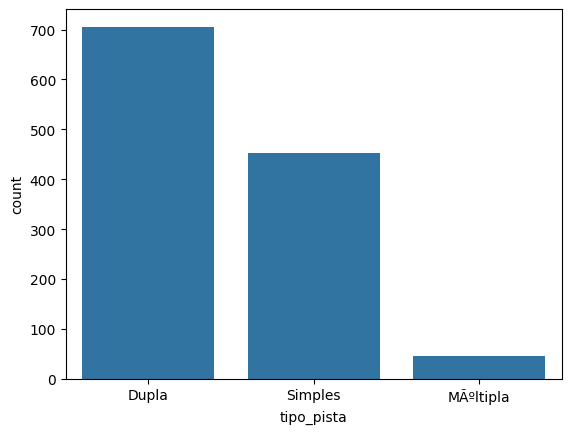

In [14]:
# Gráfico simples para verificarmos a quantidade de pista por acidentes
sns.countplot(data = df_filtrado, x = "tipo_pista")
plt.show()


***Análise Univariada (Qualitativa Nominal)***

Escolhemos Tipo de pista para a analise de qualitativa nominal, observa-se que tem 3 tipos de pista.
<ul>
<li>Dupla</li> <li>Simples</li> <li>Múltipla</li>
</ul>
Sendo o tipo de pista mais frequente a Dupla com de 60.52% de frequencia.<br>
Pista Simples aparece como a segunda categoria mais comum.<br>
A menos frequente é a pista Múltipla com menos de 3.82% de frequencia.<br>


Essa distribuição indica que a maior parte dos acidentes ao longo da BR-230 ocorre em pistas duplas, enquanto acidentes em pistas múltiplas são relativamente raros. Como se trata de uma variável qualitativa nominal, não há ordenação entre as categorias — apenas comparação de frequências.
<br>


Nesta seção escolhemos uma variavel quantitativa discreta(uma variavel do *tipo inteiro*), ainda estamos a decidir qual variavel, mais indico a variavel 'feridos' , então ja estou adiantando algo.

In [15]:
df_filtrado.groupby(['feridos']).size()

feridos
0    232
1    660
2    241
3     43
4     21
5      1
6      3
7      1
8      2
dtype: int64

In [16]:
analisar_distribuicao(df_filtrado,'feridos')

,Categoria,Quantidade,Porcentagem (%)
0,1,660,54.82
1,2,241,20.02
2,0,232,19.27
3,3,43,3.57
4,4,21,1.74
5,6,3,0.25
6,8,2,0.17
7,7,1,0.08
8,5,1,0.08


In [24]:
# Outra forma de avaliarmos uma variável especifica e exibirmos a informação. 

print('Valor mínimo: ', df_filtrado['feridos'].min())
print('Valor máximo: ', df_filtrado['feridos'].max())
print('Valor da média:' , df_filtrado['feridos'].mean())
print('Valor da médiana:', df_filtrado['feridos'].median())
print('Valor da Moda:', df_filtrado['feridos'].mode())
print('Valor do Desvio Padrão: ',df_filtrado['feridos'].std())
print('Valor do Coeficiente de Variancia(CV): ',df_filtrado['feridos'].std()/df_filtrado['feridos'].mean())

Valor mínimo:  0
Valor máximo:  8
Valor da média: 1.1636212624584719
Valor da médiana: 1.0
Valor da Moda: 0    1
Name: feridos, dtype: int64
Valor do Desvio Padrão:  0.923853386661696
Valor do Coeficiente de Variancia(CV):  0.7939468076664397


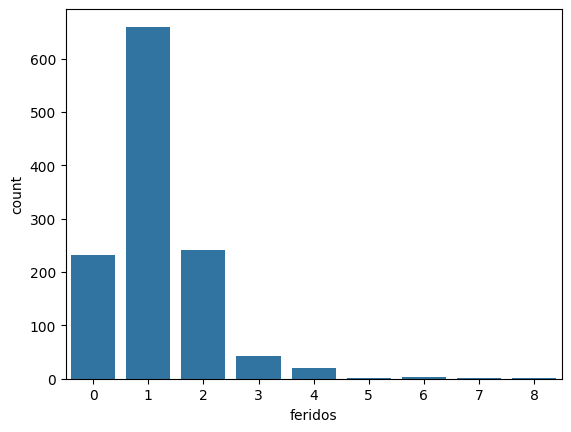

In [18]:
# Gráfico simples para verificarmos a quantidade de financiamentos por prazo
sns.countplot(data = df_filtrado, x = "feridos")
plt.show()

***Análise Univariada (Quantitativa Discreta)***

Para esta análise escolhemos a variável quantidade de feridos em cada acidente, cujo valor varia de 0 a 8.

O valor mais frequente (moda) é 1 ferido, presente em 54,82% dos acidentes.
A mediana também é 1, indicando que pelo menos metade dos acidentes possui no máximo um ferido.

A média é 1,16 feridos, um pouco maior que a mediana, o que sugere uma distribuição assimétrica à direita, causada pela presença de poucos acidentes com muitos feridos (chegando até 8).

No geral, observa-se que a maior parte dos acidentes possui poucos feridos, com forte concentração em valores baixos — especialmente em apenas um ferido, que domina a distribuição.

**Fim da Análise**

Esta seçao sera para uma analise bivariada (Sobre duas variaveis)

D. (1,0 ponto) Uma seção para análise bivariada, com pelos menos uma distribuição de
frequências e um gráfico; Interprete seus resultados.

In [ ]:
# Exemplo: Cruzar a coluna 'dia_semana' com a coluna 'classificacao_acidente'
tabela = pd.crosstab(df_filtrado['dia_semana'], df_filtrado['classificacao_acidente'])

# Dica: Use margins=True para ver os totais

tabela_com_totais = pd.crosstab(df_filtrado['dia_semana'], df_filtrado['classificacao_acidente'], margins=True)
print(tabela_com_totais)

classificacao_acidente  Com VÃ­timas Fatais  Com VÃ­timas Feridas  \
dia_semana                                                          
domingo                                  10                   115   
quarta-feira                              8                   137   
quinta-feira                              9                   136   
segunda-feira                             6                   145   
sexta-feira                               6                   143   
sÃ¡bado                                  14                   149   
terÃ§a-feira                             10                   133   
All                                      63                   958   

classificacao_acidente  Sem VÃ­timas   All  
dia_semana                                  
domingo                           45   170  
quarta-feira                      23   168  
quinta-feira                      15   160  
segunda-feira                     26   177  
sexta-feira                       22   

In [20]:
analisar_distribuicao(df_filtrado,'CAUSA_ACIDENTE').head()

,Categoria,Quantidade,Porcentagem (%)
0,AusÃªncia de reaÃ§Ã£o do condutor,187,15.53
1,ReaÃ§Ã£o tardia ou ineficiente do condutor,150,12.46
2,Acessar a via sem observar a presenÃ§a dos out...,115,9.55
3,Condutor deixou de manter distÃ¢ncia do veÃ­cu...,104,8.64
4,Manobra de mudanÃ§a de faixa,78,6.48


In [21]:
analisar_distribuicao(df_filtrado,'CAUSA_ACIDENTE').tail()

,Categoria,Quantidade,Porcentagem (%)
47,Falta de elemento de contenÃ§Ã£o que evite a s...,1,0.08
48,Problema com o freio,1,0.08
49,Redutor de velocidade em desacordo,1,0.08
50,Demais FenÃ´menos da natureza,1,0.08
51,IngestÃ£o de substÃ¢ncias psicoativas pelo con...,1,0.08


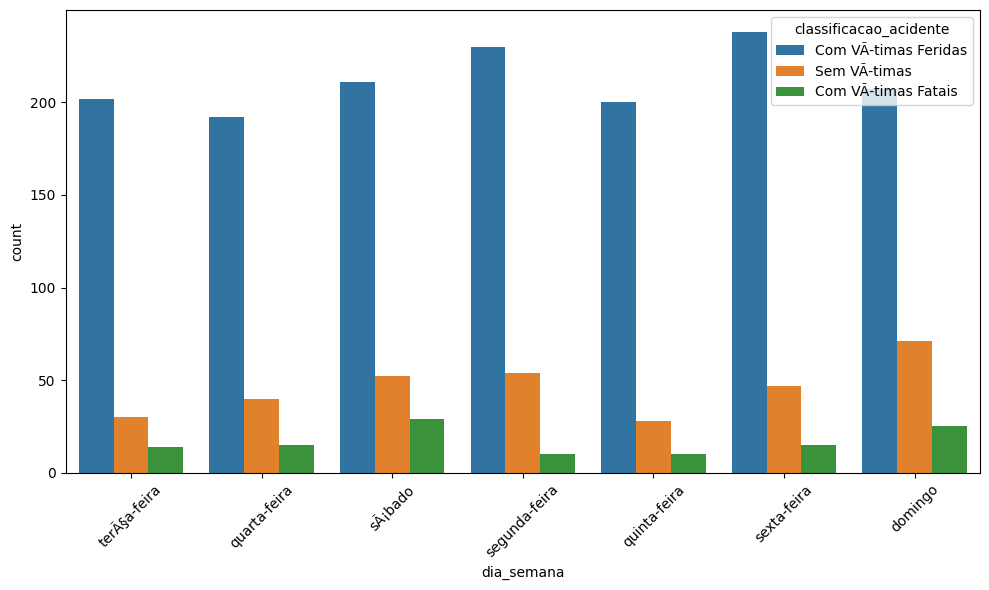

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_original, x="dia_semana", hue="classificacao_acidente")
plt.xticks(rotation=45)   # gira os nomes
plt.tight_layout()
plt.show()


outras variavies para analise bivariavel

In [ ]:
# Exemplo: Cruzar a coluna 'fase_dia' com a coluna 'classificacao_acidente'
tabela = pd.crosstab(df_filtrado['fase_dia'], df_filtrado['classificacao_acidente'])

# Dica: Use margins=True para ver os totais

tabela_com_totais = pd.crosstab(df_filtrado['fase_dia'], df_filtrado['classificacao_acidente'], margins=True)
print(tabela_com_totais)

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_original, x="fase_dia", hue="classificacao_acidente")
plt.xticks(rotation=45)   # gira os nomes
plt.tight_layout()
plt.show()
